# Features Selection MonoVariate

In [1]:
% matplotlib inline

import pickle
import time

import pandas as pd

from IPython import display as d
# from IPython import 

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn import feature_selection as fs
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split)
from sklearn import preprocessing as prp
import sklearn

from joblib import Parallel, cpu_count, delayed

from libs import container
from libs.experiment import (
    WithAnotherExperiment, KFoldExperiment, roc, 
    discretize_classes, clean_features)

%load_ext ipycache

/home/jbcabral/projects/paper_b278/local/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/home/jbcabral/projects/paper_b278/local/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


## 1. Load Data

In [2]:
start = time.time()

df = pd.read_pickle("data/normalized2500.pkl")

scaler = {k: (v0, v1) for k,v0,v1 in pickle.load(open("data/scaler.pkl"))}

##  2. Preprocess

### 2.1. Discretize the classes

In [3]:
def corrector(row):
    o3t = (row.ogle3_type or "").split("-", 1)[0]
    scls = row.scls
    return o3t, scls

classes = dict(set(map(tuple, df[["ogle3_type", "cls"]].values)))    
sclasses = dict(set(map(tuple, df[["ogle3_type", "scls"]].apply(corrector, axis=1).values)))
tclasses = {k: v for v, k in enumerate(df.tcls.unique())}

def to_tcls(row):
    tcls = str(row.tcls)
    return tclasses[tcls]

df.tcls = df.apply(to_tcls, axis=1)

d.display(d.Markdown("**Classes**"))
d.display(classes)

d.display(d.Markdown("----"))
d.display(d.Markdown("**Simplified Classes**"))
d.display(sclasses)

d.display(d.Markdown("----"))
d.display(d.Markdown("**Tile Classes**"))
d.display(tclasses)

**Classes**

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9}

----

**Simplified Classes**

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

----

**Tile Classes**

{'b261': 2, 'b262': 0, 'b263': 1, 'b264': 4, 'b278': 3}

### 2.2. Removes all low-variance and "bad" features

In [4]:
X_columns = clean_features({"df": df}, "df")
# X_columns = X_columns.drop("AndersonDarling")
X_columns = X_columns[~(X_columns.str.startswith("Freq2_") | X_columns.str.startswith("Freq3_"))]
print("Total features:", X_columns.size)

Removing [] because null
Removing [] because lowvariance
('Total features:', 55)


### 2.3. Selected features

In [5]:
X_columns

Index([u'cnt', u'Amplitude', u'Autocor_length', u'Beyond1Std', u'CAR_mean',
       u'CAR_sigma', u'CAR_tau', u'Con', u'Eta_e', u'FluxPercentileRatioMid20',
       u'FluxPercentileRatioMid35', u'FluxPercentileRatioMid50',
       u'FluxPercentileRatioMid65', u'FluxPercentileRatioMid80',
       u'Freq1_harmonics_amplitude_0', u'Freq1_harmonics_amplitude_1',
       u'Freq1_harmonics_amplitude_2', u'Freq1_harmonics_amplitude_3',
       u'Freq1_harmonics_rel_phase_1', u'Freq1_harmonics_rel_phase_2',
       u'Freq1_harmonics_rel_phase_3', u'LinearTrend', u'MaxSlope', u'Mean',
       u'Meanvariance', u'MedianAbsDev', u'MedianBRP', u'PairSlopeTrend',
       u'PercentAmplitude', u'PercentDifferenceFluxPercentile', u'PeriodLS',
       u'Psi_CS', u'Psi_eta', u'Q31', u'Rcs', u'Skew', u'SmallKurtosis',
       u'Std', u'c89_jk_color', u'c89_hk_color', u'c89_jh_color',
       u'n09_jk_color', u'n09_hk_color', u'n09_jh_color', u'c89_m2', u'c89_m4',
       u'c89_c3', u'n09_m2', u'n09_m4', u'n09_c3', u'A

In [6]:
sclasses

{'': 0, 'Cep': 1, 'LPV': 2, 'RRLyr': 3, 'T2Cep': 4}

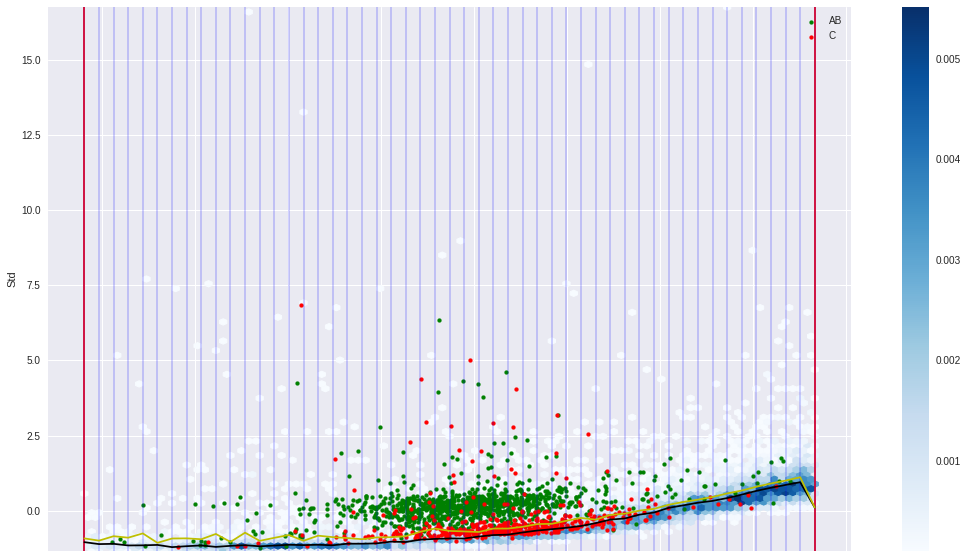

In [7]:
import numpy as np
flt = (12 - scaler["Mean"][0]) / scaler["Mean"][1], (16.5 - scaler["Mean"][0]) / scaler["Mean"][1]

def plot(data):
    all_df = data
    size = len(all_df)

    all_df['C'] = pd.Series(np.ones(size), index=all_df.index)

    unk = all_df[all_df.cls == 0]
    unk_size = len(unk)

    ax = unk.plot.hexbin(
        "Mean", "Std", cmap="Blues", C="C", 
        reduce_C_function=lambda x: (np.sum(x) / unk_size),
        figsize=(18, 10))

    all_df[all_df.cls == 6].plot.scatter("Mean", "Std", s=15, color="g", ax=ax, label="AB")
    all_df[all_df.cls == 7].plot.scatter("Mean", "Std", s=15, color="r", ax=ax, label="C")

    for limit in flt:
        ax.axvline(limit, color="r")


    bins = np.histogram(unk.Mean, bins=50)[1]

    unk = unk.assign(bins=unk.Mean.apply(np.digitize, bins=bins))

    for idx in bins:
        ax.axvline(idx, color="b", alpha=.2)

    plt.plot(bins, unk.groupby("bins")["Std"].median(), "k")
    plt.plot(bins, unk.groupby("bins")["Std"].mean(), "y")

    return ax
    
plot(df)

In [8]:
tile_unk = df.groupby("tcls").apply(lambda x: x[x.scls==0].sample(500))

min_size = df[df.scls == 3].groupby("tcls").size().min()
tile_balanced = df.groupby("tcls").apply(lambda x: x[x.scls==3].sample(min_size))

In [9]:
def experiment(clf, x_train, y_train, x_test, y_test, pos_label):
    clf = sklearn.clone(clf)
    clf.fit(x_train, y_train)

    predictions = clf.predict(x_test)
    probabilities = clf.predict_proba(x_test)

    fpr, tpr, thresholds = metrics.roc_curve(
        y_test, 1.-probabilities[:,0], pos_label=pos_label)
    prec_rec_curve = metrics.precision_recall_curve(
        y_test, 1.- probabilities[:,0], pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)

    return container.Container({
            'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'prec_rec_curve': prec_rec_curve,
            'y_test': y_test, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_test, predictions)})


# kfold
def kfolds(data, X_columns, y_column, clf, nfolds, verbose=True):
    skf = StratifiedKFold(n_splits=nfolds)

    subject_df = data

    x = subject_df[X_columns].values
    y = subject_df[y_column].values
    y_real = subject_df[y_column].values

    probabilities = None
    predictions = np.array([])
    y_testing = np.array([])
    y_testing_real = np.array([])

    for train, test in skf.split(x, y):
        x_train = x[train]
        y_train = y[train]
        x_test = x[test]
        y_test = y[test]
        y_test_real = y_real[test]

        rst = experiment(clf, x_train, y_train, x_test, y_test, pos_label=0)            
        
        probabilities = (
            rst.probabilities if probabilities is None else
            np.vstack([probabilities, rst.probabilities]))
        predictions = np.hstack([predictions, rst.predictions])
        y_testing = np.hstack([y_testing, y_test])
        y_testing_real = np.hstack([y_testing_real, y_test_real])
        del rst

    fpr, tpr, thresholds = metrics.roc_curve(
        y_testing, 1.-probabilities[:,0], pos_label=0)
    prec_rec_curve = metrics.precision_recall_curve(
        y_testing, 1.- probabilities[:,0], pos_label=0)
    roc_auc = metrics.auc(fpr, tpr)
    
    if verbose:
        print metrics.classification_report(y_testing, predictions)
        print "-" * 80

    return container.Container({
        'fpr': fpr, 
        'tpr': tpr, 
        'thresh': thresholds, 
        'roc_auc': roc_auc, 
        'prec_rec_curve': prec_rec_curve,
        'y_test': y_testing, 
        'y_test_real': y_testing_real,
        'predictions': predictions,
        'probabilities': probabilities, 
        'confusion_matrix': metrics.confusion_matrix(y_testing, predictions)})

In [10]:
%%time
clf = SVC(kernel='poly', probability=True)
kfolds(tile_balanced, X_columns, y_column="tcls", clf=clf, nfolds=10)

             precision    recall  f1-score   support

        0.0       0.27      0.16      0.20       220
        1.0       0.34      0.34      0.34       220
        2.0       0.32      0.15      0.21       220
        3.0       0.26      0.72      0.38       220
        4.0       0.39      0.07      0.12       220

avg / total       0.32      0.29      0.25      1100

--------------------------------------------------------------------------------
CPU times: user 5.26 s, sys: 0 ns, total: 5.26 s
Wall time: 5.25 s


In [11]:
%%time
clf = SVC(kernel='poly', probability=True)
kfolds(tile_unk, X_columns, y_column="tcls", clf=clf, nfolds=10)

             precision    recall  f1-score   support

        0.0       0.22      0.79      0.35       500
        1.0       0.30      0.19      0.23       500
        2.0       0.28      0.08      0.12       500
        3.0       0.49      0.11      0.18       500
        4.0       0.32      0.10      0.15       500

avg / total       0.32      0.25      0.21      2500

--------------------------------------------------------------------------------
CPU times: user 26.6 s, sys: 0 ns, total: 26.6 s
Wall time: 26.6 s


In [12]:
print "\n".join(["{} - {}".format(v, k) for k, v in sorted(tclasses.items(), key=lambda e: e[-1])])

0 - b262
1 - b263
2 - b261
3 - b278
4 - b264


# SHUFFLE

In [13]:
def shuffle_columns(df, to_shuffle):
    columns = {}
    for c in  df.columns:
        values = np.copy(df[c].values)
        if c in to_shuffle:
            np.random.shuffle(values)
        columns[c] = values
    return pd.DataFrame(columns, index=df.index.copy())

def _experiment(job_n, df, X_columns):
    print "Starting job ", job_n
    clf = SVC(kernel='poly', probability=True)
    return kfolds(
        df, X_columns, y_column="tcls", 
        clf=clf, nfolds=10, verbose=False)

In [33]:
tile_mix = pd.concat([tile_balanced, tile_unk])

In [35]:
%%cache data/mix_shuffle.pkl mix_shuffle 
with Parallel(n_jobs=cpu_count()) as jobs:
    mix_shuffle = jobs(delayed(_experiment)(idx, shuffle_columns(tile_mix, X_columns), X_columns) 
                   for idx in range(100))
mix_shuffle = map(dict, mix_shuffle)

[Skipped the cell's code and loaded variables mix_shuffle from file '/home/jbcabral/projects/paper_b278/src/data/mix_shuffle.pkl'.]


In [32]:
%%cache data/rr_shuffle.pkl rr_shuffle 
with Parallel(n_jobs=cpu_count()) as jobs:
    rr_shuffle = jobs(delayed(_experiment)(idx, shuffle_columns(tile_balanced, X_columns), X_columns) 
                   for idx in range(100))
rr_shuffle = map(dict, rr_shuffle)

[Skipped the cell's code and loaded variables rr_shuffle from file '/home/jbcabral/projects/paper_b278/src/data/rr_shuffle.pkl'.]


In [18]:
%%cache data/unk_shuffle.pkl unk_shuffle
with Parallel(n_jobs=cpu_count()) as jobs:
    unk_shuffle = jobs(delayed(_experiment)(idx, shuffle_columns(tile_unk, X_columns), X_columns) 
                   for idx in range(2))
unk_shuffle = map(dict, unk_shuffle)

[Skipped the cell's code and loaded variables unk_shuffle from file '/home/jbcabral/projects/paper_b278/src/data/unk_shuffle.pkl'.]


In [36]:
mix_shuffle = map(container.Container, mix_shuffle)
rr_shuffle = map(container.Container, rr_shuffle)
unk_shuffle = map(container.Container, unk_shuffle)

In [37]:
def mean_r(results):
    precs, recalls, f1s, supports = [], [], [], []
    for r in results:
        prec, recall, f1, sup = metrics.precision_recall_fscore_support(
            r.y_test, r.predictions, labels=tclasses.values(),
            average=None, sample_weight=None)
        precs.append(prec)
        recalls.append(recall)
        f1s.append(f1)
        supports.append(sup)
    precs = pd.DataFrame(precs)
    recalls = pd.DataFrame(recalls)
    f1s = pd.DataFrame(f1s)
    supports = pd.DataFrame(supports)
    return (
        precs.mean(axis=0).values,
        recalls.mean(axis=0).values,
        f1s.mean(axis=0).values,
        supports.mean(axis=0).values)

def var_r(results):
    precs, recalls, f1s, supports = [], [], [], []
    for r in results:
        prec, recall, f1, sup = metrics.precision_recall_fscore_support(
            r.y_test, r.predictions, labels=tclasses.values(),
            average=None, sample_weight=None)
        precs.append(prec)
        recalls.append(recall)
        f1s.append(f1)
        supports.append(sup)
    precs = pd.DataFrame(precs)
    recalls = pd.DataFrame(recalls)
    f1s = pd.DataFrame(f1s)
    supports = pd.DataFrame(supports)
    return (
        precs.var(axis=0).values,
        recalls.var(axis=0).values,
        f1s.var(axis=0).values,
        supports.var(axis=0).values)

In [21]:
def print_r(r):
    dt = dict(zip(["precision", "recall", "f1-score", "support"], r))
    df = pd.DataFrame(dt)
    means_row = df.mean(axis=0).to_dict()
    new_index = list(df.index) + ["avg / total"]
    df = df.append(means_row, ignore_index=True)
    df = df.assign(new_index=new_index)
    df = df.set_index("new_index")
    return df

In [38]:
d.display(d.Markdown("## RRLyrae + Unknow stars"))
d.display(d.Markdown("### Average"))
display(print_r(mean_r(results=mix_shuffle)))
d.display(d.Markdown("### Var"))
display(print_r(var_r(results=mix_shuffle)))

## RRLyrae + Unknow stars

### Average

,f1-score,precision,recall,support
new_index,,,,
0,0.156099,0.201629,0.164014,720.0
1,0.168553,0.198356,0.207764,720.0
2,0.162447,0.204001,0.191625,720.0
3,0.175340,0.201804,0.222361,720.0
4,0.169466,0.203581,0.214542,720.0
avg / total,0.166381,0.201874,0.200061,720.0


### Var

,f1-score,precision,recall,support
new_index,,,,
0,0.004061,0.000560,0.020427,0.0
1,0.006191,0.000468,0.038468,0.0
2,0.006118,0.000589,0.034734,0.0
3,0.006290,0.000587,0.038351,0.0
4,0.006741,0.000566,0.043496,0.0
avg / total,0.005880,0.000554,0.035095,0.0


In [25]:
d.display(d.Markdown("## RRLyrae"))
d.display(d.Markdown("### Average"))
display(print_r(mean_r(results=rr_shuffle)))
d.display(d.Markdown("### Var"))
display(print_r(var_r(results=rr_shuffle)))

## RRLyrae

### Average

,f1-score,precision,recall,support
new_index,,,,
0,0.163814,0.196740,0.178045,220.0
1,0.181132,0.205147,0.214045,220.0
2,0.172437,0.205395,0.206773,220.0
3,0.168585,0.201356,0.191773,220.0
4,0.171297,0.199091,0.208000,220.0
avg / total,0.171453,0.201546,0.199727,220.0


### Var

,f1-score,precision,recall,support
new_index,,,,
0,0.005050,0.001321,0.023522,0.0
1,0.005081,0.001184,0.028934,0.0
2,0.005754,0.002265,0.032284,0.0
3,0.005385,0.001735,0.028167,0.0
4,0.006457,0.001609,0.034819,0.0
avg / total,0.005545,0.001623,0.029545,0.0


In [26]:
d.display(d.Markdown("## Unknow stars"))
d.display(d.Markdown("### Average"))
display(print_r(mean_r(results=unk_shuffle)))
d.display(d.Markdown("### Var"))
display(print_r(var_r(results=unk_shuffle)))

## Unknow stars

### Average

,f1-score,precision,recall,support
new_index,,,,
0,0.201583,0.198482,0.2580,500.0
1,0.086867,0.185083,0.0570,500.0
2,0.175061,0.193873,0.1600,500.0
3,0.199749,0.217270,0.3240,500.0
4,0.177393,0.193920,0.1890,500.0
avg / total,0.168131,0.197725,0.1976,500.0


### Var

,f1-score,precision,recall,support
new_index,,,,
0,0.010157,0.000033,0.051200,0.0
1,0.000047,0.000160,0.000050,0.0
2,0.000375,0.000099,0.000648,0.0
3,0.019712,0.000532,0.135200,0.0
4,0.004510,0.000096,0.017298,0.0
avg / total,0.006960,0.000184,0.040879,0.0
